In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE, KMeansSMOTE, SMOTEN, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

metrics_data_columns = ['k_neighbour', 'train_accuracy', 'test_accuracy', 'roc_auc',
                         'precision_0', 'recall_0', 'f1_0',
                         'precision_1', 'recall_1', 'f1_1', 
                         'ks_stat', 'p_value', 
                         'tp', 'tn', 'fp', 'fn']

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install crucio

In [3]:
evaluation_files_loc = './class_imbalance_methods_evaluations/'
if not os.path.exists(evaluation_files_loc):
    os.mkdir(evaluation_files_loc)

### Reading data

In [4]:
# File location of the dataset
data_loc = "./Churn_Modelling.csv"

# Read the CSV file into a Pandas DataFrame, using the first column as the index
df = pd.read_csv(data_loc, index_col=0)

df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Unique values in each column

In [5]:
for idx,column in enumerate(df.columns):
    # Get the unique values in the current column
    unique_values = df[column].unique()
    
    print("{}. {:<20} :: Unique value count :: {:<10}".format(idx,column, len(unique_values)), end='')
    
    # If the number of unique values is less than 15
    if len(unique_values) < 15:
        print(f" :: {sorted(unique_values)}")
        
    # If the number of unique values is greater than or equal to 15, don't display the values
    else:
        print()

0. CustomerId           :: Unique value count :: 10000     
1. Surname              :: Unique value count :: 2932      
2. CreditScore          :: Unique value count :: 460       
3. Geography            :: Unique value count :: 3          :: ['France', 'Germany', 'Spain']
4. Gender               :: Unique value count :: 2          :: ['Female', 'Male']
5. Age                  :: Unique value count :: 70        
6. Tenure               :: Unique value count :: 11         :: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
7. Balance              :: Unique value count :: 6382      
8. NumOfProducts        :: Unique value count :: 4          :: [1, 2, 3, 4]
9. HasCrCard            :: Unique value count :: 2          :: [0, 1]
10. IsActiveMember       :: Unique value count :: 2          :: [0, 1]
11. EstimatedSalary      :: Unique value count :: 9999      
12. Exited               :: Unique value count :: 2          :: [0, 1]


# Basic understanding about dataset

- RowNumber: the index of the row in the dataset
- CustomerId: a unique identifier for each customer
- CreditScore: the customer's credit score
- Age: the customer's age
- Tenure: the number of years the customer has been with the bank
- Balance: the customer's account balance
- NumOfProducts: the number of bank products the customer has
- HasCrCard: whether the customer has a credit card with the bank (1=yes, 0=no)
- IsActiveMember: whether the customer is an active member of the bank (1=yes, 0=no)
- EstimatedSalary: the customer's estimated salary
- Exited: whether the customer has churned (left the bank) (1=yes, 0=no)

## Class Distribution

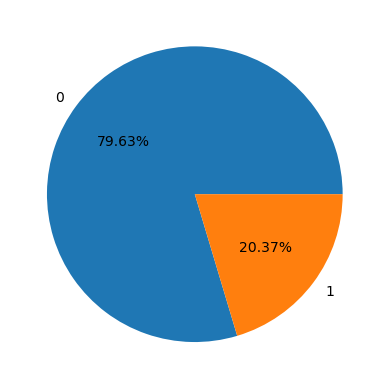

In [6]:
plt.pie(df["Exited"].value_counts(), 
        labels=sorted(df['Exited'].unique()),
        autopct='%1.2f%%')
plt.show()

## Correlation Matrix

<Axes: >

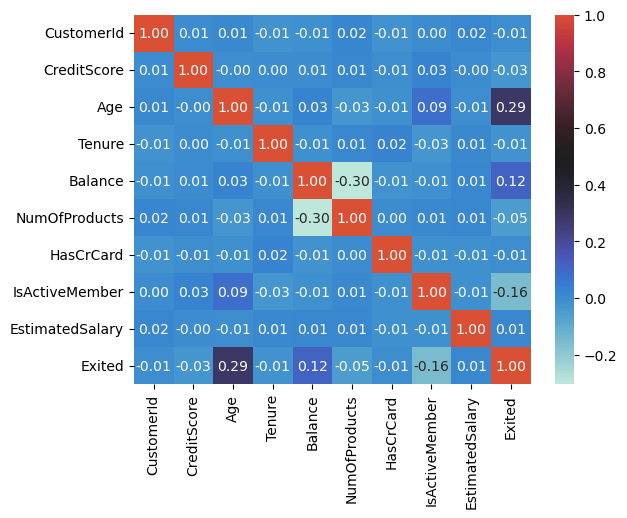

In [7]:
sns.heatmap(df[df.describe().columns].corr(),
            annot=True,
            fmt='.2f',
            center=0.5)

### Drop all categorical columns

In [4]:
df.drop(['CustomerId', 'Surname','Geography', 'Gender'], axis = 1,inplace=True)
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1
2,608,41,1,83807.86,1,0,1,112542.58,0
3,502,42,8,159660.80,3,1,0,113931.57,1
4,699,39,1,0.00,2,0,0,93826.63,0
5,850,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...
9996,771,39,5,0.00,2,1,0,96270.64,0
9997,516,35,10,57369.61,1,1,1,101699.77,0
9998,709,36,7,0.00,1,0,1,42085.58,1


## Functions for model training and evaluation

In [5]:
def features_target_split(df, target_col='Exited'):
    """
    Split the DataFrame into features and target variables.
    
    Parameters:
        df (DataFrame): The input DataFrame.
        target_col (str): The name of the target column. Default is 'Exited'.
        
    Returns:
        x (DataFrame): The features.
        y (Series): The target variable.
    """
    # Drop the target column from the DataFrame to get the features
    x = df.drop(target_col, axis=1)
    
    # Assign the target column as the y variable
    y = df[target_col]
    
    # Return the features and target variables
    return x,y


def train_test_split(x,y,df,target_col='Exited', test_size=0.2, random_state=42):
    """
    Split the features and target variables into training and testing sets.
    
    Parameters:
        x (DataFrame): The features.
        y (Series): The target variable.
        df (DataFrame): The original DataFrame.
        target_col (str): The name of the target column. Default is 'Exited'.
        test_size (float or int): The proportion or absolute number of samples to include in the testing set. Default is 0.2.
        random_state (int): The seed used by the random number generator. Default is 42.
        
    Returns:
        x_train (DataFrame): The training set features.
        x_test (DataFrame): The testing set features.
        y_train (Series): The training set target variable.
        y_test (Series): The testing set target variable.
    """
    from sklearn.model_selection import train_test_split
    
    # Split the features and target variables into training and testing sets
    # Stratified is being used to maintain the proportion of class [0 and 1] in splits.
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state, 
                                                        stratify=df[target_col])
    
    return x_train, x_test, y_train, y_test

def logistic_model_train(x_train, y_train, random_state=42, max_iter=1000):
    """
    Train a logistic regression model using the provided training data.
    
    Parameters:
        x_train (DataFrame): The training set features.
        y_train (Series): The training set target variable.
        random_state (int): The seed used by the random number generator. Default is 42.
        max_iter (int): The maximum number of iterations for the solver to converge. Default is 1000.
        
    Returns:
        log_reg_model (LogisticRegression): The trained logistic regression model.
    """
    
    # Create an instance of LogisticRegression model with specified random_state and max_iter
    log_reg_model = LogisticRegression(random_state=random_state, max_iter=max_iter)
    
    # Fit the logistic regression model to the training data
    log_reg_model.fit(x_train, y_train)
    
    return log_reg_model

def prediction(log_reg_model, x_train, x_test):
    """
    Generate predictions using a trained logistic regression model.
    
    Parameters:
        log_reg_model (LogisticRegression): The trained logistic regression model.
        x_train (array-like or sparse matrix): The training set features.
        x_test (array-like or sparse matrix): The testing set features.
        
    Returns:
        y_pred_train (array-like): Predicted labels for the training set.
        y_pred_test (array-like): Predicted labels for the testing set.
        y_pred_test_proba (array-like): Predicted probabilities for the testing set.
    """
    # Generate predictions for the training set
    y_pred_train = log_reg_model.predict(x_train)
    
    # Generate predictions for the testing set
    y_pred_test = log_reg_model.predict(x_test)
    
    # Generate predicted probabilities for the testing set
    y_pred_test_proba = log_reg_model.predict_proba(x_test)
    
    return y_pred_train, y_pred_test, y_pred_test_proba


class Evaluation():
    def __init__(self,y_train, y_test, y_pred_train, y_pred_test, y_pred_test_proba):
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred_train = y_pred_train
        self.y_pred_test = y_pred_test
        self.y_pred_test_proba = y_pred_test_proba
    
    def __ks_stats_value__(self):
        """
        Calculate the Kolmogorov-Smirnov (KS) statistic and p-value.
        
        Returns:
            ks_stat (float): The KS statistic.
            p_value (float): The p-value.
        """
        
        # proba_non_churn contains the predicted probabilities for instances that did not churn
        proba_non_churn = self.y_pred_test_proba[:,1][self.y_test==0]
        
        # proba_churn contains the predicted probabilities for instances that actually churned
        proba_churn = self.y_pred_test_proba[:,1][self.y_test==1]
        
        # Calculating Kolmogorov-Smirnov (KS) statistic and p-value
        ks_stat, p_value = ks_2samp(proba_non_churn, proba_churn)
        return ks_stat, p_value
    
    def __accuracy_value__(self):
        train_accuracy = accuracy_score(self.y_train, self.y_pred_train)
        test_accuracy = accuracy_score(self.y_test, self.y_pred_test)
        return train_accuracy, test_accuracy

    def __prec_rec_f1_value__(self, pos_label):
        """
        Calculate precision, recall, and F1-score for a given label.
        
        Parameters:
            pos_label: The label for which metrics are calculated.
        
        Returns:
            precision (float): Precision score.
            recall (float): Recall score.
            f1 (float): F1-score.
        """
        precision = precision_score(self.y_test, self.y_pred_test,pos_label=pos_label)
        recall = recall_score(self.y_test, self.y_pred_test,pos_label=pos_label)
        f1 = f1_score(self.y_test, self.y_pred_test, pos_label=pos_label)
        return precision, recall, f1

    def __roc_value__(self):
        roc_auc = roc_auc_score(self.y_test, self.y_pred_test)
        return roc_auc

    def __confusion_matrix_value__(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred_test).ravel()
        return tn, fp, fn, tp
    
    def main(self):
        train_accuracy, test_accuracy = self.__accuracy_value__()
        
        precision_0, recall_0, f1_0 = self.__prec_rec_f1_value__(pos_label=0)
        precision_1, recall_1, f1_1 = self.__prec_rec_f1_value__(pos_label=1)
        
        ks_stat, p_value = self.__ks_stats_value__()
        
        roc_auc = self.__roc_value__()
        
        tn, fp, fn, tp = self.__confusion_matrix_value__()
        
        all_metrics = [train_accuracy, test_accuracy, roc_auc, 
                       precision_0, recall_0, f1_0, 
                       precision_1, recall_1, f1_1, 
                       ks_stat, p_value, 
                       tp, tn, fp, fn]
        
        all_metrics = [round(value, ndigits=6) for value in all_metrics]
        all_metrics_dict = {'train_acc':all_metrics[0], 'test_acc':all_metrics[1], 'roc_auc':all_metrics[2],  
                            'class_0':{'precision':all_metrics[3], 'recall':all_metrics[4], 'f1':all_metrics[5]}, 
                            'class_1':{'precision':all_metrics[6], 'recall':all_metrics[7], 'f1':all_metrics[8]},
                            'ks_stats':all_metrics[9], 'p_value':all_metrics[10],
                            'tp':all_metrics[11],'tn':all_metrics[12],'fp':all_metrics[13],'fn':all_metrics[14]}
        
        return all_metrics, all_metrics_dict

# Techniques to handle class-imbalance 

In [6]:
def smote_method(x,y,neighbour):
    # Apply SMOTE
    sm = SMOTE(random_state=42, k_neighbors=neighbour)
    x_new, y_new = sm.fit_resample(x,y)
    
    return x_new, y_new

In [7]:
def adasyn_method(x,y,neighbour):
    adap_synt = ADASYN(random_state=42, n_neighbors=neighbour)
    x_new, y_new = adap_synt.fit_resample(x,y)
    
    return x_new, y_new

In [8]:
def borderline_smote_method(x,y,neighbour):
    border_smote = BorderlineSMOTE(random_state=42, k_neighbors=neighbour)
    x_new, y_new = border_smote.fit_resample(x,y)

    return x_new, y_new

In [9]:
def kmeans_smote_method(x,y,neighbour):
    kmeans_smote = KMeansSMOTE(random_state=42, k_neighbors=neighbour,cluster_balance_threshold=0.2)
    x_new, y_new = kmeans_smote.fit_resample(x,y)

    return x_new, y_new

In [10]:
def smoten_method(x,y,neighbour):
    # Apply SMOTEN
    sm = SMOTEN(random_state=42, k_neighbors=neighbour)
    x_new, y_new = sm.fit_resample(x,y)
    
    return x_new, y_new

In [11]:
def smotenc_method(x,y,neighbour, approach_type):
    
    # File location of the dataset
    data_loc = "./Churn_Modelling.csv"

    # Read the CSV file into a Pandas DataFrame, using the first column as the index
    df = pd.read_csv(data_loc, index_col=0)
    
    df.drop(['CustomerId'], axis = 1,inplace=True)
    
    if approach_type == 1:
    
        x,y = features_target_split(df)

        # Apply SMOTENC
        sm = SMOTENC(categorical_features=[0,2,3],random_state=42, k_neighbors=neighbour)
        x_new, y_new = sm.fit_resample(x,y)

        x_new.drop(['Surname', 'Geography', 'Gender'], axis = 1,inplace=True)
        
        return x_new, y_new
    
    if approach_type == 2:
        x,y = features_target_split(df)
        
        # Split the features and target variables into training and testing sets.
        x_train, x_test, y_train, y_test = train_test_split(x,y,df)

        # Apply SMOTENC
        sm = SMOTENC(categorical_features=[0,2,3],random_state=42, k_neighbors=neighbour)
        x_train_new, y_train_new = sm.fit_resample(x_train,y_train)

        x_train_new.drop(['Surname', 'Geography', 'Gender'], axis = 1,inplace=True)
        
        x_test.drop(['Surname', 'Geography', 'Gender'], axis = 1,inplace=True)
        
        return x_train_new, x_test, y_train_new, y_test 

In [12]:
def svm_smote_method(x,y,neighbour):
    # Apply SVMSMOTE
    sm = SVMSMOTE(random_state=42, k_neighbors=neighbour)
    x_new, y_new = sm.fit_resample(x,y)
    
    return x_new, y_new

In [13]:
def smote_enn_method(x,y,neighbour):
    # Apply SMOTEENN
    sm = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=neighbour))
    x_new, y_new = sm.fit_resample(x,y)
    
    return x_new, y_new

In [14]:
def smote_tomek_method(x,y,neighbour):
    # Apply SMOTETOMEK
    sm = SMOTETomek(random_state=42, smote=SMOTE(random_state=42, k_neighbors=neighbour))
    x_new, y_new = sm.fit_resample(x,y)
    
    return x_new, y_new

## Base Logistic Regression model

In [15]:
# Split the DataFrame into features and target variables.
x,y = features_target_split(df)

In [17]:
# Split the features and target variables into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(x,y,df)

In [17]:
# Train a logistic regression model
log_reg_model = logistic_model_train(x_train, y_train)

In [18]:
# Generate predictions
y_pred_train, y_pred_test, y_pred_test_proba = prediction(log_reg_model, x_train, x_test)

In [19]:
# Calculate evaluation metrics
model_evaluation = Evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_test_proba)
_, eval_ = model_evaluation.main()
eval_

/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'train_acc': 0.79625,
 'test_acc': 0.7965,
 'roc_auc': 0.5,
 'class_0': {'precision': 0.7965, 'recall': 1.0, 'f1': 0.886724},
 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'ks_stats': 0.096574,
 'p_value': 0.004357,
 'tp': 0,
 'tn': 1593,
 'fp': 0,
 'fn': 407}

In [1]:
1593+407

2000

# Two approach for implementation::
    1. On whole dataset [before train, test split] [APPROACH 1]
    2. Only on train data [after train, test split] [APPROACH 2]

## APPROACH 1

In [19]:
def approach_one(df, method_name):
    
    print(f"\nUsing {method_name.upper()} :: APPROACH 1 :: ")
    
    metrics_data = []
    
    if method_name == 'kmeans_smote':
        # No cluster are formed beyond this value of k
        stop_range = 480
        
    elif method_name == 'smotenc':
        # RAM issue
        stop_range = 100
        
    else:
        stop_range = df.Exited.value_counts()[1]

    for neighbour in range(1,stop_range):

        # Split the DataFrame into features and target variables.
        x,y = features_target_split(df)

        if method_name == 'smote':
            # Apply SMOTE
            x_new, y_new = smote_method(x,y,neighbour)

        if method_name == 'adasyn':
            # Apply ADASYN
            x_new, y_new = adasyn_method(x,y,neighbour)
            
        if method_name == 'borderline_smote':
            # Apply Borderline SMOTE
            x_new, y_new = borderline_smote_method(x,y,neighbour)
            
        if method_name == 'kmeans_smote':
            # Apply K-Means SMOTE
            x_new, y_new = kmeans_smote_method(x,y,neighbour)
            
        if method_name == 'smoten':
            # Apply SMOTEN
            x_new, y_new = smoten_method(x,y,neighbour)
            
        if method_name == 'smotenc':
            # Apply SMOTENC
            x_new, y_new = smotenc_method(x,y,neighbour, approach_type=1)
            
        if method_name == 'svmsmote':
            # Apply SVMSMOTE
            x_new, y_new = svm_smote_method(x,y,neighbour)
            
        if method_name == 'smoteenn':
            # Apply SMOTEENN
            x_new, y_new = smote_enn_method(x,y,neighbour)
            
        if method_name == 'smotetomek':
            # Apply SMOTETOMEK
            x_new, y_new = smote_tomek_method(x,y,neighbour)

        # Prepare new dataframe using generate data
        df_new = pd.concat([x_new, y_new], axis=1)

        # Split the DataFrame into features and target variables.
        x,y = features_target_split(df_new)

        # Split the features and target variables into training and testing sets.
        x_train, x_test, y_train, y_test = train_test_split(x,y,df_new)

        # Train a logistic regression model
        log_reg_model = logistic_model_train(x_train, y_train)

        # Generate predictions
        y_pred_train, y_pred_test, y_pred_test_proba = prediction(log_reg_model, x_train, x_test)

        # Calculate evaluation metrics
        model_evaluation = Evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_test_proba)
        all_metrics,_ = model_evaluation.main()

        # inserting value of k in all_metrics
        all_metrics.insert(0, neighbour)

        metrics_data.append(all_metrics)
        
        print(f"\n{neighbour}. Train Acc: {all_metrics[1]} :: Test Acc: {all_metrics[2]}", end='')

#         if neighbour%500 == 0 or neighbour == 1:
#             print(f"\n{neighbour}. Train Acc: {all_metrics[1]} :: Test Acc: {all_metrics[2]}",end='')
#         else:
#             if neighbour%10 == 0:
#                 print('.', end='')
    
#         break
    metrics_df = pd.DataFrame(data=metrics_data, columns=metrics_data_columns)
    metrics_df.to_csv(os.path.join(evaluation_files_loc ,f"./app_1_{method_name}_eval.csv"), header=True, index=False)

## APPROACH 2

In [20]:
def approach_two(df, method_name):
    
    print(f"\nUsing {method_name.upper()} :: APPROACH 2 :: ")
    
    metrics_data = []

    # Split the DataFrame into features and target variables.
    x,y = features_target_split(df)

    # Split the features and target variables into training and testing sets.
    x_train, x_test, y_train, y_test = train_test_split(x,y,df)
    
    if method_name == 'kmeans_smote':
        # No cluster are formed beyond this value of k
        stop_range = 339
        
    elif method_name == 'smotenc':
        # RAM issue
        stop_range = 150
        
    else:
        stop_range = y_train.value_counts()[1]


    for neighbour in range(1,stop_range):
        
        if method_name == 'smote':
            # Apply SMOTE
            x_train_new, y_train_new = smote_method(x_train,y_train,neighbour)

        if method_name == 'adasyn':
            # Apply ADASYN
            x_train_new, y_train_new = adasyn_method(x_train,y_train,neighbour)

        if method_name == 'borderline_smote':
            # Apply Borderline SMOTE
            x_train_new, y_train_new = borderline_smote_method(x_train,y_train,neighbour)
            
        if method_name == 'kmeans_smote':
            # Apply KMeans SMOTE
            x_train_new, y_train_new = kmeans_smote_method(x_train,y_train,neighbour)
            
        if method_name == 'smoten':
            # Apply SMOTEN
            x_train_new, y_train_new = smoten_method(x_train,y_train,neighbour)
            
        if method_name == 'smotenc':
            # Apply SMOTENC
            x_train_new, x_test, y_train_new, y_test = smotenc_method(x_train,y_train,neighbour, approach_type=2)
            
        if method_name == 'svmsmote':
            # Apply SVMSMOTE
            x_train_new, y_train_new = svm_smote_method(x_train,y_train,neighbour)
            
        if method_name == 'smoteenn':
            # Apply SMOTEENN
            x_train_new, y_train_new = smote_enn_method(x_train,y_train,neighbour)
            
        if method_name == 'smotetomek':
            # Apply SMOTETOMEK
            x_train_new, y_train_new = smote_tomek_method(x_train,y_train,neighbour)
            
        # Train a logistic regression model
        log_reg_model = logistic_model_train(x_train_new, y_train_new)

        # Generate predictions
        y_pred_train, y_pred_test, y_pred_test_proba = prediction(log_reg_model, x_train_new, x_test)

        # Calculate evaluation metrics
        model_evaluation = Evaluation(y_train_new, y_test, y_pred_train, y_pred_test, y_pred_test_proba)
        all_metrics,_ = model_evaluation.main()

        # inserting value of k in all_metrics
        all_metrics.insert(0, neighbour)

        metrics_data.append(all_metrics)
        
        print(f"\n{neighbour}. Train Acc: {all_metrics[1]} :: Test Acc: {all_metrics[2]}" , end='')

#         if neighbour%500 == 0 or neighbour == 1:
#             print(f"\n{neighbour}. Train Acc: {all_metrics[1]} :: Test Acc: {all_metrics[2]}", end='')
#         else:
#             if neighbour%10 == 0:
#                 print('.',end='')
#         break
    metrics_df = pd.DataFrame(data=metrics_data, columns=metrics_data_columns)
    metrics_df.to_csv(os.path.join(evaluation_files_loc,f"./app_2_{method_name}_eval.csv"), header=True, index=False)

In [21]:
# methods_ = ['smote', 'adasyn', 'borderline_smote', 'kmeans_smote', 'smoten', 'smotenc' , 'svmsmote', 'smoteenn', 'smotetomek']
# methods_ = ['svmsmote', 'smoteenn', 'smotetomek']
methods_ = ['smotenc']

In [22]:
def time_logs(appr,method_name,tt):
    with open('./class_imbalance_methods_evaluations/time_logs', 'a') as fp:
        fp.writelines(f"approach_{appr},{method_name},{tt}" + '\n')

In [23]:
for mth in methods_:
    print()
#     print('#'*50)
#     start_time = time()
#     approach_one(df, method_name=mth)
#     end_time = time()
#     print("\nTime :: ", end_time-start_time)
#     time_logs('1',mth, round(end_time-start_time, ndigits=6))
    
    start_time = time()
    approach_two(df, method_name=mth)
    end_time = time()
    print("\nTime :: ", end_time-start_time)
    time_logs('2',mth,round(end_time-start_time, ndigits=6))



Using SMOTENC :: APPROACH 2 :: 

1. Train Acc: 0.670251 :: Test Acc: 0.645
2. Train Acc: 0.672057 :: Test Acc: 0.647
3. Train Acc: 0.668524 :: Test Acc: 0.6475
4. Train Acc: 0.669309 :: Test Acc: 0.646
5. Train Acc: 0.667818 :: Test Acc: 0.6445
6. Train Acc: 0.664521 :: Test Acc: 0.6445
7. Train Acc: 0.665934 :: Test Acc: 0.6455
8. Train Acc: 0.668995 :: Test Acc: 0.6485
9. Train Acc: 0.744035 :: Test Acc: 0.7015
10. Train Acc: 0.666327 :: Test Acc: 0.646
11. Train Acc: 0.5719 :: Test Acc: 0.5065
12. Train Acc: 0.670016 :: Test Acc: 0.646
13. Train Acc: 0.668446 :: Test Acc: 0.645
14. Train Acc: 0.662402 :: Test Acc: 0.6435
15. Train Acc: 0.663736 :: Test Acc: 0.646
16. Train Acc: 0.667033 :: Test Acc: 0.6495
17. Train Acc: 0.663422 :: Test Acc: 0.6445
18. Train Acc: 0.669074 :: Test Acc: 0.648
19. Train Acc: 0.668995 :: Test Acc: 0.648
20. Train Acc: 0.668053 :: Test Acc: 0.648
21. Train Acc: 0.670879 :: Test Acc: 0.6465
22. Train Acc: 0.575667 :: Test Acc: 0.5025
23. Train Acc: 0.6